## STEAL (Coarse to fine) 

Cityscapes Demo 

"""
Copyright (c) 2019, NVIDIA CORPORATION. All rights reserved.
"""


In [1]:
import sys
sys.version

'3.7.4 (default, Aug 13 2019, 20:35:49) \n[GCC 7.3.0]'

In [2]:
import torch
import numpy as np
import torch.utils.data
from models.casenet import casenet101 as CaseNet101
from coarse_to_fine.input_reader import InputReaderSemMatDemo
from inference_cityscapes import do_test
import cv2
from contours import ContourBox
import utils.vis_utils as vs_utils
import os
from utils.VisualizerBox import VisualizerBox
import matplotlib.pyplot as plt

In [3]:
# Define input file path and coarse annotation file.
image_paths = [
    './demo/coarse_to_fine/augsburg_000000_001266_leftImg8bit.png']

coarse_gt_paths = [
    './demo/coarse_to_fine/augsburg_000000_001266_leftImg8bit.mat']
classes_to_refine = [11, 12, 13, 14, 15, 16, 17, 18]


In [4]:
# --- Initializing the coarse gt reader
ireader_coarse = InputReaderSemMatDemo(None, None, [1, 19])
ireader_coarse.set_external_list(coarse_gt_paths)
ireader_coarse.set_classes_to_keep(classes_to_refine)


In [6]:
# Initializing network and pretrained model.
ckpt = './checkpoints/cityscapes/model_checkpoint.pt'
net = CaseNet101(nclasses=19)
net = torch.nn.DataParallel(net.cuda())
net.load_state_dict(torch.load(ckpt), strict=True)

Assuming Cityscapes CASENET


<All keys matched successfully>

In [7]:
## Initializing Contour Box
level_set_config_dict = {
    'step_ckpts': [0, 30, 50,80],
    'lambda_': 0.0,
    'alpha': 1,
    'smoothing': 1,
    'render_radius': -1,
    'is_gt_semantic': True,
    'method': 'MLS',
    'balloon': 1,
    'threshold': 0.99,
    'merge_weight': 0.5
}

cbox = ContourBox.LevelSetAlignment(n_workers=1,
                                    fn_post_process_callback=None,
                                    config=level_set_config_dict)

LevelSet Alignment n_workers:  1
 LevelSetAlignment config:  {'step_ckpts': [0, 30, 50, 80], 'lambda_': 0.0, 'alpha': 1, 'smoothing': 1, 'render_radius': -1, 'is_gt_semantic': True, 'method': 'MLS', 'balloon': 1, 'threshold': 0.99, 'merge_weight': 0.5}


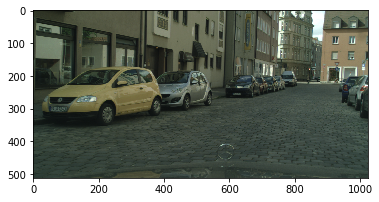

100%|██████████| 1/1 [00:09<00:00,  9.20s/it]


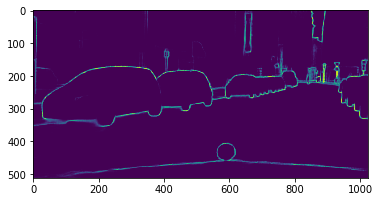

In [8]:
## Inference and resizing.
rgb_image = vs_utils.read_resize_image(image_paths[0], show=True)
pred = do_test(net, output_folder=None, test_lst=image_paths, n_classes=19)[0]
pred = cv2.resize(pred, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_NEAREST).transpose((2, 0, 1))
plt.imshow(np.max(pred,axis=0))
# ---

In [9]:
# Reading Coarse GT and Removing ignore classes.
_, seg_coarse = list(ireader_coarse)[0]
pred_ = np.array([pred[id]  for _, id in ireader_coarse._remapping.items()])


In [10]:
# Alignment 
output, _ = cbox({'seg': np.expand_dims(seg_coarse, 0), 'bdry': None},
                 np.expand_dims(pred_, 0))

In [11]:
# Visualization
vis_box = VisualizerBox(dataset_color='css4_fushia', plt_backend=None, fig_size=(15, 40))
vis_box.set_output_folder(os.path.join('./output_dir', 'demo', 'vis'))

plot_pairs = {'Coarse Label': seg_coarse, 'Semantic Edges': np.max(pred_, axis=0, keepdims=True)}

for vis_step in range(len(level_set_config_dict['step_ckpts'])):
    masks_step = output[0, :, vis_step, :, :]
    vis_step = level_set_config_dict['step_ckpts'][vis_step]
    plot_pairs['(step_%.2i)' % vis_step] = masks_step


dataset color: css4_fushia
Vis Output Dir: ./output_dir/demo/vis


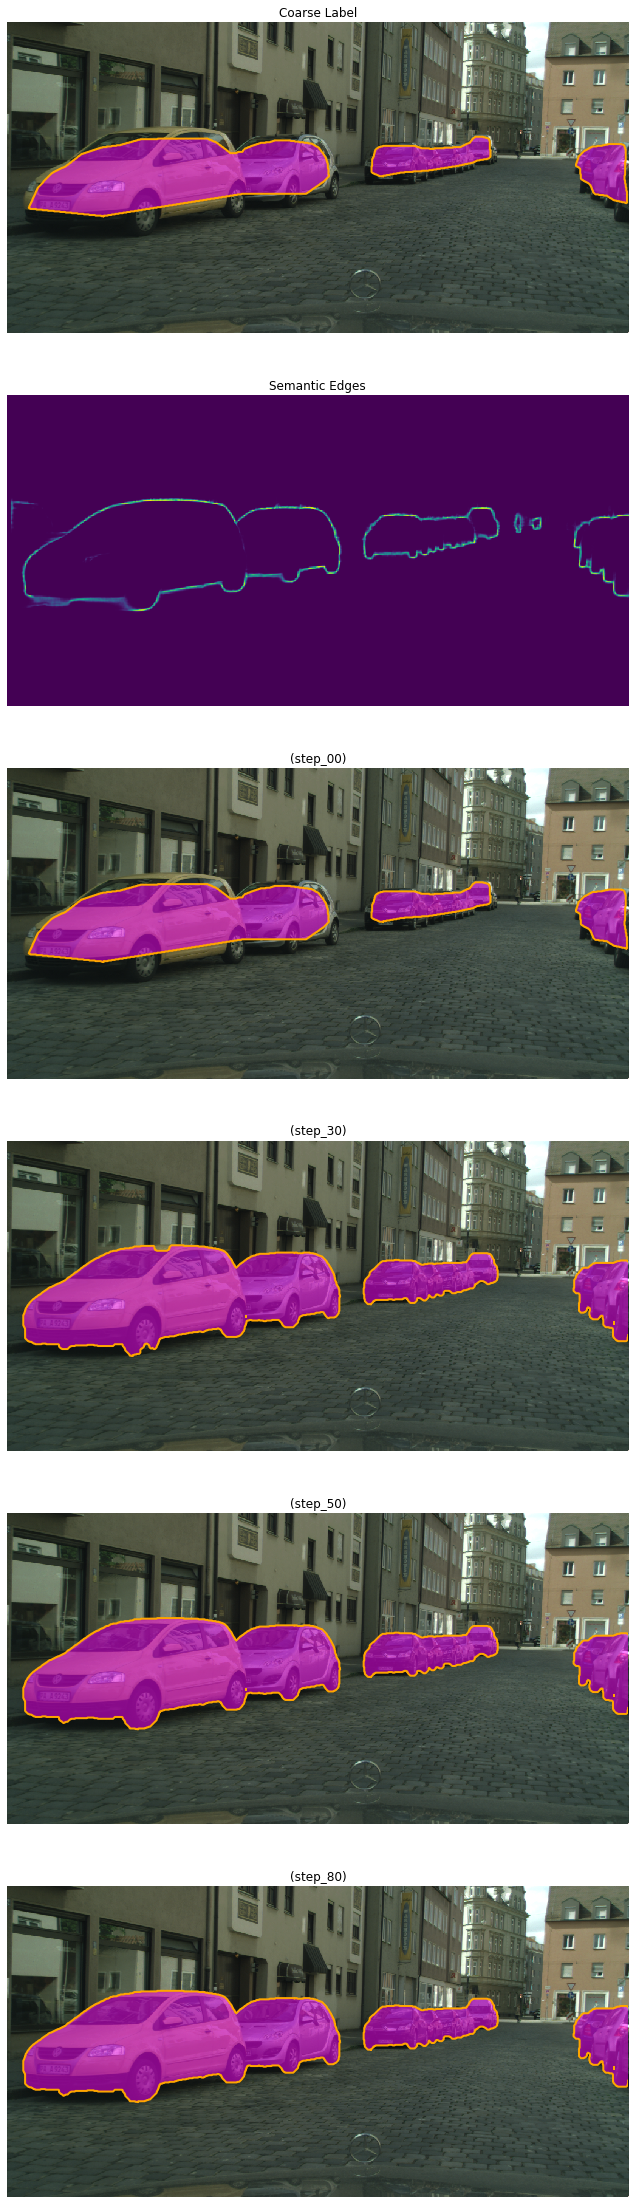

In [12]:
vis_box.visualize(plot_pairs, background=rgb_image,
                              remapping_dict=ireader_coarse._remapping,
                              grid=True,merge_channels=True)